No handles with labels found to put in legend.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9957
Date:                Mon, 12 Jul 2021   Prob (F-statistic):              0.379
Time:                        17:45:52   Log-Likelihood:                 222.22
No. Observations:                  41   AIC:                            -438.4
Df Residuals:                      38   BIC:                            -433.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
HDI           -0.0015      0.003     -0.473      0.6

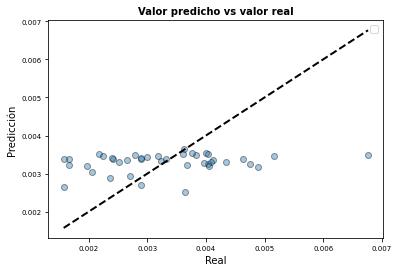

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np
pd.options.mode.chained_assignment = None
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

data = pd.read_csv('https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto10/FallecidosEtario_T.csv', sep=',')
data['sumando'] = data[['<=39','40-49','50-59','60-69','70-79','80-89','>=90']].sum(axis=1)
data['Total_dia'] = '' 

for i in range(len(data['Total_dia'])):
    if i == 0:
        data['Total_dia'][i] = data['sumando'][i]
    else:
        data['Total_dia'][i] = data['sumando'][i] - data['sumando'][i-1]

x = data['Total_dia']

#Datos desde el 24 de diciembre de 2020 (cuando se empezaron a administrar vacunas)        
for idx, d in enumerate(data['Grupo de edad']):
    if d == '2020-12-24':
        indice = idx

muertes_covid_sem = []
contador = 0
suma = 0
for idx, i in enumerate(range(len(x))):
    if idx >= indice:
        suma += x[i]
        if contador == 6:
            muertes_covid_sem.append(suma)
            suma = 0
            contador = 0
        else:
            contador += 1

data_2 = pd.read_csv('https://raw.githubusercontent.com/leoferres/gitiele356b/main/data/hdi.csv', sep=',')

archivo = open('C:\\Users\\Javi\\Desktop\\Tabla cruzada-Región Ocurrencia-Comuna.csv','r')
lector = csv.reader(archivo, delimiter=";")

vac_comunas = []
for fila in lector:
    if lector.line_num > 1:
        comuna = {'nombre':fila[0], 'codigo':fila[7], 'porcentaje':fila[6], 'poblacion':fila[5]}
        vac_comunas.append(comuna)
        
for c in vac_comunas:
    c['porcentaje'] = int(c['porcentaje'].replace('%',''))
    c['poblacion'] = int(str(c['poblacion'].replace('.','')))

data_3 = pd.read_csv('https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto50/DefuncionesDEIS_confirmadosPorComuna.csv', sep=',')

for i in range(len(data_3['Codigo region'])):
    if str(data_3['Codigo region'][i]) != '13':
        data_3 = data_3.drop([i], axis=0)

data_3 = data_3.drop([140], axis=0)

for idx, d in enumerate(data_3):
    if d == '2020-12-24':
        indice_2 = idx

data_3 = data_3.drop(data_3.columns[range(5,indice_2)], axis='columns')

datos = np.matrix(data_3)

filas = len(data_3)
columnas = len(data_3.columns)

comunas = []
for fila in range(filas):
    muertes_sem_comuna = []
    contador = 0
    suma = 0
    for col in range(5, columnas):
        suma += int(datos[fila, col])
        if contador == 6:
            muertes_sem_comuna.append(suma)
            suma = 0
            contador = 0
        else:
            contador +=1
    comuna = {'codigo':int(datos[fila, 3]), 'muertes_sem':muertes_sem_comuna}
    comunas.append(comuna)
    
for c in comunas:
    suma = 0
    promedio = 0
    for i in c['muertes_sem']:
        suma += i
    promedio = suma/len(c['muertes_sem']) 
    c['prom_muertes_sem'] = promedio

for i in range(len(data_2['comuna'])):
    for c in comunas:
        if int(c['codigo']) == int(data_2['comuna'][i]):
            c['HDI'] = float(data_2['HDI'][i])

for v in vac_comunas:
    for c in comunas:
        if int(c['codigo']) == int(v['codigo']):
            c['porcentaje'] = v['porcentaje']
            c['poblacion'] = v['poblacion']
            
for c in comunas:
    c['%_muertes_sem'] = (c['prom_muertes_sem']/c['poblacion'])*100

df = pd.DataFrame(comunas)
df = df.drop(['muertes_sem', 'codigo', 'poblacion', 'prom_muertes_sem'], axis=1)

correlacion = df.corr(method='pearson')

X = df[['HDI', 'porcentaje']]
Y = df['%_muertes_sem']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y.values.reshape(-1,1), train_size=0.8, random_state=1234, shuffle=True)

X_train = sm.add_constant(X_train, prepend=False)
modelo = sm.OLS(endog=Y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

Y_train = Y_train.flatten()
prediccion_train = modelo.predict(exog = X_train)

plt.scatter(Y_train, prediccion_train, edgecolors=(0, 0, 0), alpha = 0.4)
plt.plot([Y_train.min(), Y_train.max()], [Y_train.min(), Y_train.max()], 'k--', color = 'black', lw=2)

plt.title('Valor predicho vs valor real', fontsize = 10, fontweight = "bold")
plt.xlabel('Real')
plt.ylabel('Predicción')
plt.tick_params(labelsize = 7)
plt.legend()
plt.show()

#porcentaje muertes = 0.005 - 0.0015*HDI - 0.000007351*porcentaje
#Donde porcentaje muertes representa el porcentaje de muertes semanales de cada comuna en relación a su población

In [ ]:
# El modelo de regresión lineal múltiple:
# porcentaje muertes = 0.005 - 0.0015*HDI - 0.000007351*porcentaje
# Donde porcentaje muertes representa el porcentaje de muertes semanales de cada comuna en relación a su población
# Es capaz de explicar el 5% de la varianza observada en el porcentaje de muertes semanales por comuna (R-squared = 0.05).
# Por otr lado, se puede decir que el coeficiente de relacion R es muy bajo, con un valor de aproximadamente 22%, lo que 
# quiere decir que las variables poseen una baja correlación entre sí.

# Dentro de los factores independientes, se puede encontrar el HDI y el porcentaje, mientras que el factor dependiente
# corresponde al porcentaje de muertes. Se observa que ambos factores independientes influyen negativamente en el dependiente, 
# teniendo más relevancia el HDI.

# El modelo lineal presentado refleja que el efecto sobre el porcentaje de muertes semanales en cada comuna producto
# de un aumento en el HDI es independiente del que provoca un incremento en el porcentaje de vacunación. Dicho modelo considera
# que el porcentaje de muertes semanales por comuna disminuye en 0,0015% al aumentar en una unidad el HDI, mientras que
# disminuye en un 0.000007351% al aumentar en 1% el porcentaje de vacunación de la respectiva comuna.

# En relación a la prueba omnibus, se puede decir que el modelo no logra explicar el evento dado que la significancia es de
# aproximadamente un 16%, es decir, las variables independientes no logran explicar las variables dependientes.



